Start by importing libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier

from statsmodels.base.model import GenericLikelihoodModel
import statsmodels.api as sm

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
df = pd.read_csv('CISS_Merged_Cleaned.csv', low_memory = False)

In [3]:
df.columns

Index(['Unnamed: 0', 'CASENO', 'CRASHMONTH', 'DAYOFWEEK', 'CRASHTIME',
       'MANCOLL', 'CASEWGT', 'ID', 'VEHNO', 'MODELYR', 'DAMPLANE',
       'SPEEDLIMIT', 'PARALCOHOL', 'RELTOJUNCT', 'TRAFFLOW', 'LIGHTCOND',
       'WEATHER', 'DISTRACT', 'DVTOTAL', 'DVEST', 'DV', 'DISTRACTN', 'OCCNO',
       'MAIS', 'SEATLOC', 'AGE', 'HEIGHT', 'WEIGHT', 'SEX', 'PARBELTUSE',
       'PARAIRBAG', 'BELTUSE', 'CHILDSEATUSE', 'TREATMENT', 'MEDFACILITY',
       'HOSPSTAY', 'EMSDATA', 'BMI', 'Distracted', 'Looked_no_see', 'Driver',
       'FrontPax', 'Back_Left', 'Back_Middle', 'Back_Right', 'DeltaV',
       'Airbag_Deploy', 'Male', 'No_Seatbelt', 'Poor_Weather', 'Alcohol',
       'DV1025', 'DV2540', 'DV4055', 'DV55Pl', 'DV_Minor', 'DV_Moder',
       'DV_Severe', 'Front', 'Left', 'Right', 'Junction_related'],
      dtype='object')

In [4]:
df.MAIS.value_counts()

0     1728
1     1324
99     302
2      277
9      217
3      164
4       45
5       24
6       15
Name: MAIS, dtype: int64

In [5]:
df['MAIS1'] = np.where(df['MAIS']>6,1,df['MAIS']) # code "99" and "9" values to a value of 1, which is commonly done in biomechanical injury research
df['MAIS_red'] = np.where(df['MAIS1']>3,4,df['MAIS1']) # combine 4-6 into a singel category, which is commonly done in biomechanical injury research

In [6]:
df.dtypes

Unnamed: 0            int64
CASENO                int64
CRASHMONTH          float64
DAYOFWEEK           float64
CRASHTIME            object
MANCOLL             float64
CASEWGT             float64
ID                    int64
VEHNO               float64
MODELYR             float64
DAMPLANE             object
SPEEDLIMIT          float64
PARALCOHOL          float64
RELTOJUNCT          float64
TRAFFLOW            float64
LIGHTCOND           float64
WEATHER             float64
DISTRACT            float64
DVTOTAL             float64
DVEST               float64
DV                  float64
DISTRACTN           float64
OCCNO                 int64
MAIS                  int64
SEATLOC               int64
AGE                 float64
HEIGHT              float64
WEIGHT              float64
SEX                   int64
PARBELTUSE            int64
                     ...   
MEDFACILITY           int64
HOSPSTAY              int64
EMSDATA               int64
BMI                   int64
Distracted          

In [7]:
#df['Airbag_Deploy'] = df['Airbag_Deploy'].astype(str).astype(int)
df['Airbag_Deploy'].value_counts()

Deployed               1903
Not Deployed           1620
Not Reported            407
None Available          125
Unknown                  31
Unknown if Deployed      10
Name: Airbag_Deploy, dtype: int64

In [8]:
df['Airbag'] = np.where(df['Airbag_Deploy']=='Deployed',1,0)

In [9]:
covariates = ['Distracted', 'Looked_no_see', 'Driver',
       'FrontPax', 'Back_Left', 'Back_Middle', 'Back_Right', 
       'Airbag', 'Male', 'No_Seatbelt', 'Poor_Weather', 'Alcohol',
       'DV1025', 'DV2540', 'DV4055', 'DV55Pl', 'DV_Minor', 'DV_Moder',
       'DV_Severe', 'Front', 'Left', 'Right', 'Junction_related']

X= df[covariates]
y= df['MAIS_red']
groups = df['MODELYR']
weights = df['CASEWGT']

X_train, X_test, y_train, y_test, groups_train, groups_test, weight_train, weight_test = train_test_split(X, y, groups, weights, test_size=.3, random_state=1653)

In [10]:
# X_train, y_train, groups_train
X_train.dtypes

Distracted          int64
Looked_no_see       int64
Driver              int64
FrontPax            int64
Back_Left           int64
Back_Middle         int64
Back_Right          int64
Airbag              int64
Male                int64
No_Seatbelt         int64
Poor_Weather        int64
Alcohol             int64
DV1025              int64
DV2540              int64
DV4055              int64
DV55Pl              int64
DV_Minor            int64
DV_Moder            int64
DV_Severe           int64
Front               int64
Left                int64
Right               int64
Junction_related    int64
dtype: object

In [11]:
print(X_train.shape)
print(y_train.shape)
print(groups_train.shape)
print(weight_train.shape)

(2867, 23)
(2867,)
(2867,)
(2867,)


In [12]:
y_train.value_counts()

1    1297
0    1209
2     184
3     115
4      62
Name: MAIS_red, dtype: int64

Install and import mord (ordinal logistic regression package)

In [14]:
!pip install mord

  Created wheel for mord: filename=mord-0.6-cp36-none-any.whl size=6861 sha256=be2f4ccf399674123098124c29008a3f7c9918030f0790c95a3274ce876023a0
  Stored in directory: /home/nbuser/.cache/pip/wheels/98/14/b2/244c2cec93a0c6edb29b488bd6b2710ded7e9d457033b86366
Successfully built mord
You should consider upgrading via the 'pip install --upgrade pip' command.


In [15]:
from mord import LogisticAT

# Run ordinal logit using mord

For the ordinal logistic regression, the probability for each value (using the values for the data in this analysis, or 0-4) are shown in the following equations: <br> <br>
$$P(MAIS>0) = \frac{exp(intercept_0 + \beta X)}{1+exp(intercept_0 + \beta X)}$$ <br>
$$P(MAIS>1) = \frac{exp(intercept_1 + \beta X)}{1+exp(intercept_1 + \beta X)}$$ <br>
$$P(MAIS>2) = \frac{exp(intercept_2 + \beta X)}{1+exp(intercept_2 + \beta X)}$$ <br>
$$P(MAIS>3) = \frac{exp(intercept_3 + \beta X)}{1+exp(intercept_3 + \beta X)}$$ <br> <br>
It follows that: <br>
$$P(MAIS=0) = 1 - P(MAIS>0)$$ <br>
$$P(MAIS=1) = P(MAIS>0) - P(MAIS>1) $$ <br>
$$P(MAIS=2) = P(MAIS>1) - P(MAIS>2) $$ <br>
$$P(MAIS=3) = P(MAIS>2) - P(MAIS>3) $$ <br>
$$P(MIAS=4) = P(MAIS>3)$$

In [16]:
# instantiate models
model_ordinal = LogisticAT(alpha=0)  # alpha parameter set to zero to perform no regularisation. This makes the results consistent with the statsmodels results
model_ordinal.fit(X_train, y_train)

LogisticAT(alpha=0, max_iter=1000, verbose=0)

In [17]:
y_pred_ord = model_ordinal.predict(X_test)
print(confusion_matrix(y_test, y_pred_ord))

[[311 207   1   0   0]
 [163 366  12   4   1]
 [  9  80   3   1   0]
 [  2  36   8   3   0]
 [  6  12   1   3   0]]


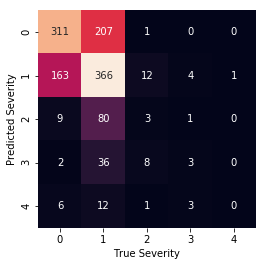

In [19]:
# Plot the confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_ord), square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True Severity')
plt.ylabel('Predicted Severity');

## Define function for GK Gamma Correlation 
This measures how well two ordinal scales correlate with each other. This is ideal for comparing observed vs. predicted values on an ordinal scale. Details of the methodology can be found at:
https://doi.org/10.2307%2F2281536 <br>
Examples can be found at: https://www.statisticshowto.com/gamma-coefficient-goodman-kruskal/ <br>
$$G = \frac{N_{concordant} - N_{discordant}}{N_{concordant} + N_{discordant}}$$ <br>
With <br>
$$t = G \sqrt{\frac{N_{concordant} + N_{discordant}}{N(1-G^2)}}$$ <br>
Where: <br> 
$N =$ the total number of observations, <br>
$N_{concordant} = $ the number of pairs of cases ranked in the same order on both variables (observed and predicted, in this case), and <br>
$N_{discordant} = $ the number of pairs of cases ranked in reversed order on both variables (observed and predicted, in this case) <br> <br>
Given that a confusion matrix is being used (i.e., a contingency table), the concordant and discordant counts are found using: <br>
$$N_{concordant} = \sum_{i} \sum_j N_{ij} \bigg(\sum_{k>i} \sum_{l>j} N_{jk}\bigg)$$ <br>
$$N_{discordant} = \sum_{i} \sum_j N_{ij} \bigg(\sum_{k>i} \sum_{l<j} N_{jk}\bigg)$$

In [20]:
def gkgamma(obs, pred): # GK Gamma Correlation based on Confusion Matrix
    from scipy.stats import norm
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(obs, pred)
    concordant = 0
    discordant = 0


    for i in range(0,len(cm)):
        for j in range(0,len(cm)):
            for k in range(0,len(cm)):
                for l in range(0,len(cm)):
                    if (i>k) & (j>l):
                        concordant += cm[i][j]*cm[k][l]
                    if (i<k) & (j>l):
                        discordant += cm[i][j]*cm[k][l]
    gkgamma_corr = (concordant - discordant)/(concordant + discordant) 
    t_stat = gkgamma_corr*(((concordant + discordant))/(sum(sum(cm))*(1-gkgamma_corr**2)))**0.5
    p_value = 2*norm.cdf(-1*abs(t_stat))
    print('GK Gamma = ' + str(round(gkgamma_corr,3)))
    print('t-statistic = ' + str(round(t_stat,3)))
    if p_value >= 0.001:
        print('p-value = ' + str(round(p_value,3)))
    else:
        print('p-value < 0.001')
    #return gkgamma_corr, t_stat, p_value

In [21]:
gkgamma(y_test, y_pred_ord) # GK Gamma Correlation for Test Data

GK Gamma = 0.621
t-statistic = 11.377
p-value < 0.001


In [22]:
gkgamma(y_train, model_ordinal.predict(X_train)) # GK Gamma Correlation for Training Data

GK Gamma = 0.632
t-statistic = 17.736
p-value < 0.001


# Running Ordinal Logit using Statsmodels - seeing parameters and model summary
Note - The results are same as when using "mord", but it is easier to get the parameters and standard errors, etc. However, "mord" is easier to use to obtain class predictions (statsmodels only predicts the probability of the observed class using the "predict" option).

In [23]:
covariates = ['Distracted', 'FrontPax', 'Back_Left', 'Back_Middle', 'Back_Right', 
       'Airbag', 'Male', 'No_Seatbelt', 'Poor_Weather', 'Alcohol',
       'DV1025', 'DV2540', 'DV4055', 'DV55Pl', 'DV_Minor', 'DV_Moder',
       'DV_Severe', 'Front', 'Left']



X= df[covariates]
y= df['MAIS_red']
groups = df['MODELYR']
weights = df['CASEWGT']

X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(X, y, groups,  test_size=.3, random_state=1653)

In [24]:
ind = sm.cov_struct.Independence()
model0 = sm.OrdinalGEE(y_train, X_train, groups_train, cov_struct=ind)
result0 = model0.fit()
print(result0.summary())
print(ind.summary())

                           OrdinalGEE Regression Results                           
Dep. Variable:                    MAIS_red   No. Observations:                11468
Model:                          OrdinalGEE   No. clusters:                       38
Method:                        Generalized   Min. cluster size:                   4
                      Estimating Equations   Max. cluster size:                1236
Family:                           Binomial   Mean cluster size:               301.8
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 23 Jun 2020   Scale:                           1.000
Covariance type:                    robust   Time:                         13:48:00
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
I(y>0.0)         0.0327      0.123      0.266      0.790      -0.208       0.273
I

It is interesting to note that the intercept for y > 0 is not statistically significant (p-value = 0.790). Variables with p-values larger than 0.05 were included to reduce the likelihood of omitted variables bias. Surprisingly, airbag deployment has a positive coefficient, indicating injury severity increases with airbag deployment. This is likely capturing unobserved variables as airbags are only deployed in collisions with high levels of energy.

# Run Random Forest

In [25]:
model = RandomForestClassifier(n_estimators = 100, random_state=2512, min_samples_leaf=10, max_depth=15) # I played with the hyperoarameters here.

In [26]:
model.fit(X_train, y_train) #set to train

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=2512, verbose=0,
            warm_start=False)

In [27]:
y_pred_rf = model.predict(X_test)
print(confusion_matrix(y_test, y_pred_rf)) 

[[326 193   0   0   0]
 [173 373   0   0   0]
 [ 15  78   0   0   0]
 [  5  44   0   0   0]
 [ 10  12   0   0   0]]


In [28]:
gkgamma(y_train, model.predict(X_train)) # GK Gamma Correlation for Training Data

GK Gamma = 0.595
t-statistic = 15.789
p-value < 0.001


In [29]:
gkgamma(y_test, y_pred_rf) # GK Gamma Correlation for Test Data

GK Gamma = 0.569
t-statistic = 9.703
p-value < 0.001


It is interesting to note that the GK Gamma results for the Rand Forest are smaller than for the ordinal logit.

In [30]:
# Import GridSearchCV from sklearn's model selection library
from sklearn.model_selection import GridSearchCV

print('Processing GridSearch. Please hold for the next available set of outputs.\n')
parameters = {"max_depth": [5,6,7,8,9,10,11,12,13,14,15]
             ,"n_estimators" : [100]
             ,"min_samples_leaf": [5,6,7,8,9,10]}

rf = RandomForestClassifier(random_state=2512)
gd_model = GridSearchCV(rf, parameters, n_jobs = -1, cv=10)
gd_model.fit(X,y)

print(gd_model.best_params_)
print(gd_model.best_estimator_)
print(gd_model.best_score_)

Processing GridSearch. Please hold for the next available set of outputs.

{'max_depth': 5, 'min_samples_leaf': 8, 'n_estimators': 100}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=2512, verbose=0,
            warm_start=False)
0.560302734375


In [31]:
model = RandomForestClassifier(n_estimators = 100, random_state=2512, min_samples_leaf=9, max_depth=6) # Based on results of grid search
model.fit(X_train, y_train) #set to train
y_pred_rf = model.predict(X_test)
print(confusion_matrix(y_test, y_pred_rf)) 

[[333 186   0   0   0]
 [178 368   0   0   0]
 [ 16  77   0   0   0]
 [  3  46   0   0   0]
 [  9  13   0   0   0]]


In [32]:
gkgamma(y_test, y_pred_rf) # GK Gamma Correlation for Test Data on optimized RF

GK Gamma = 0.589
t-statistic = 10.243
p-value < 0.001


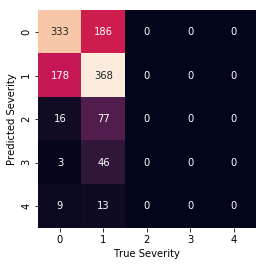

In [33]:
# Plot the confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_rf), square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True Severity')
plt.ylabel('Predicted Severity');

Even with the grid search, the GK Gamma is smaller for the Random Forest than for the ordinal logit

## Given that there are no predictions for AIS 2+, try other hyperparameters

GK Gamma = 0.453
t-statistic = 7.356
p-value < 0.001


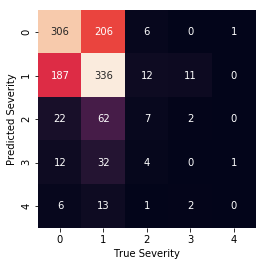

In [35]:
model = RandomForestClassifier(n_estimators = 100, random_state=2512, min_samples_leaf=1, max_depth=20) 
model.fit(X_train, y_train) #set to train
y_pred_rf = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rf)
gkgamma(y_test, y_pred_rf) # GK Gamma Correlation for Test Data on optimized RF
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True Severity')
plt.ylabel('Predicted Severity');

GK Gamma = 0.54
t-statistic = 9.107
p-value < 0.001


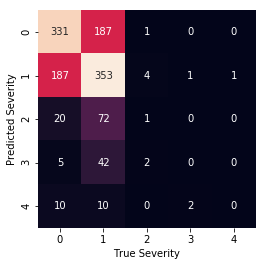

In [37]:
model2 = RandomForestClassifier(n_estimators = 100, random_state=2512, min_samples_leaf=2, max_depth=10) 
model2.fit(X_train, y_train) #set to train
y_pred_rf = model2.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rf)
gkgamma(y_test, y_pred_rf) # GK Gamma Correlation for Test Data on optimized RF
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True Severity')
plt.ylabel('Predicted Severity');

GK Gamma = 0.514
t-statistic = 8.522
p-value < 0.001


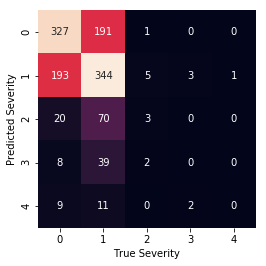

In [38]:
model3 = RandomForestClassifier(n_estimators = 100, random_state=2512, min_samples_leaf=2, max_depth=20) 
model3.fit(X_train, y_train) #set to train
y_pred_rf = model3.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rf)
gkgamma(y_test, y_pred_rf) # GK Gamma Correlation for Test Data on optimized RF
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True Severity')
plt.ylabel('Predicted Severity');

Using model2: Best looking confusion matrix and highest GK Gamma of the revised three Random Forest models

In [39]:
imps = model2.feature_importances_
df2 = X.columns.get_values()
features = df2.tolist() 

df3 = pd.DataFrame()
df3['features']=features
df3['imps']=imps
df3 = df3.sort_values('imps')
df3

,features,imps
13,DV55Pl,0.009725
12,DV4055,0.011924
3,Back_Middle,0.013973
8,Poor_Weather,0.016358
4,Back_Right,0.024740
15,DV_Moder,0.025881
14,DV_Minor,0.026439
16,DV_Severe,0.034752
18,Left,0.037230
2,Back_Left,0.039699


<Figure size 432x288 with 0 Axes>

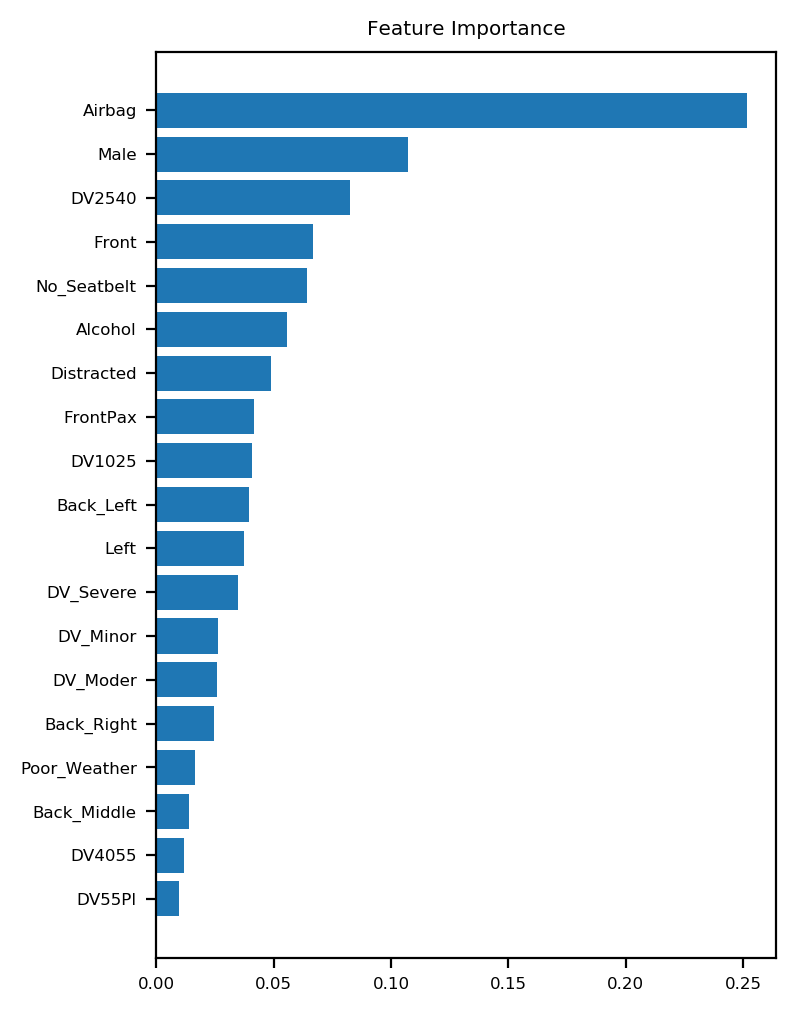

In [40]:
# Create plot
plt.rcParams.update({'font.size': 6})
plt.figure()
plt.figure(figsize=(4, 6), dpi=200)

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.barh(df3['features'], df3['imps'])
#plt.ylabel("Importance", fontsize = 12)


# Add feature names as x-axis labels
#plt.xticks(imps, features, rotation=90)

# Show plot
plt.show()

# Plot effects of changes in predictor variables on changes in predicted injury severities for test data (i.e., partial dependence plots [PDP])

In [102]:
# function for evaluating binary predictor and generating plot
def pdp_binary(var, x=0.5, y1=1.25, y2=0.75):
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'figure.figsize': [10,10]})
    x0 = X_test.copy()
    x1 = X_test.copy()
    x0[var] = np.zeros(len(x0)) #set variable of interest equal to "0"
    x1[var] = np.ones(len(x1)) #set variable of interest equal to "1"

    # Ordinal Logit
    y_pred_ord_0 = model_ordinal.predict(x0)
    y_pred_ord_1 = model_ordinal.predict(x1)
    y_ord_diff = np.subtract(y_pred_ord_1, y_pred_ord_0)

    # Random Forest
    y_pred_rf_0 = model2.predict(x0)
    y_pred_rf_1 = model2.predict(x1)
    y_rf_diff = np.subtract(y_pred_rf_1, y_pred_rf_0)

    plt.hist([y_ord_diff, y_rf_diff], label = ['Ordinal Logit', 'Random Forest'], density = True)
    plt.legend()
    plt.xlabel('Change in Predicted Severity Level for {}'.format(var))
    plt.ylabel('Density')
    plt.annotate('Ordinal logit mean change \nfor ' + var + ' = ' + str(round(np.mean(y_ord_diff),3)),(x,y1))
    plt.annotate('Random forest mean change \nfor ' + var + ' = ' + str(round(np.mean(y_rf_diff),3)),(x,y2))
    plt.show()

In [48]:
model_ordinal.fit(X_train, y_train) # re-run ordinal logit - otherwise the predictions are not working

LogisticAT(alpha=0, max_iter=1000, verbose=0)

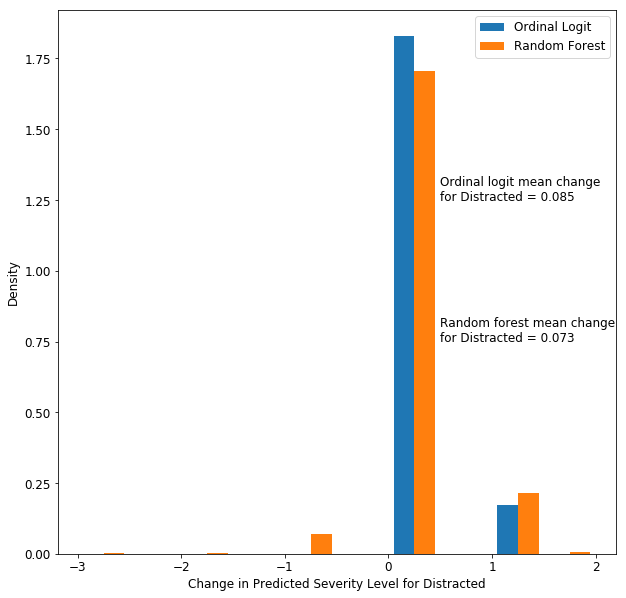

In [103]:
# Variable = Distracted
pdp_binary('Distracted', x=0.5, y1=1.25, y2=0.75)

For "Distracted", it is interesting that the Random Forest has some differences that are positive and some that are negative while the Ordinal Logit has positive or no change. Similar findings are found for each variable included in the models, as shown below.

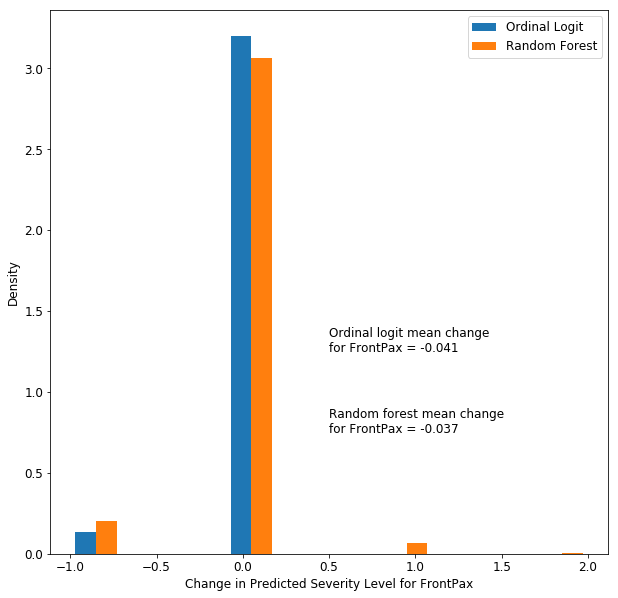

In [104]:
pdp_binary('FrontPax', x=0.5, y1=1.25, y2=0.75)

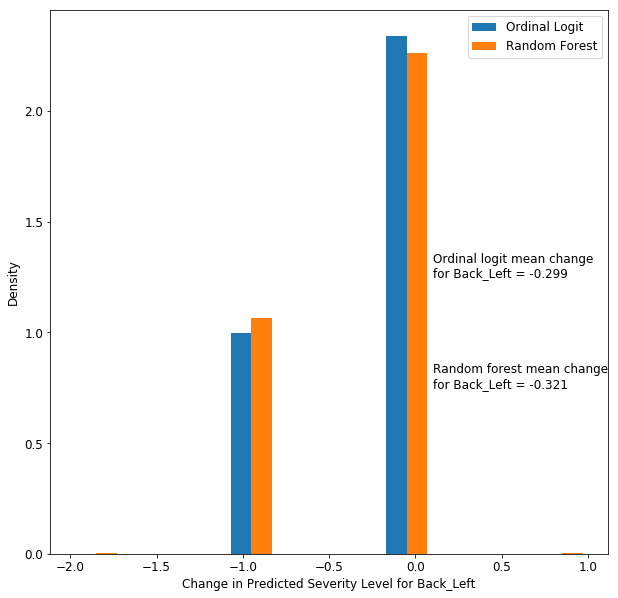

In [105]:
pdp_binary('Back_Left', x=0.1, y1=1.25, y2=0.75)

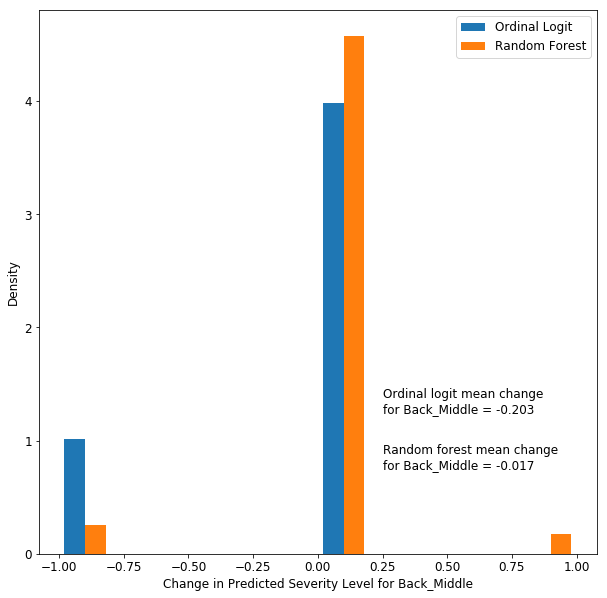

In [106]:
pdp_binary('Back_Middle', x=0.25, y1=1.25, y2=0.75)

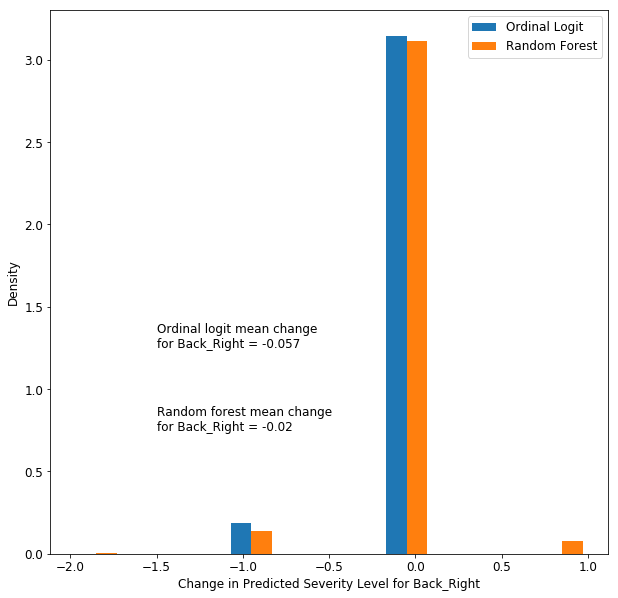

In [107]:
pdp_binary('Back_Right', x=-1.5, y1=1.25, y2=0.75)

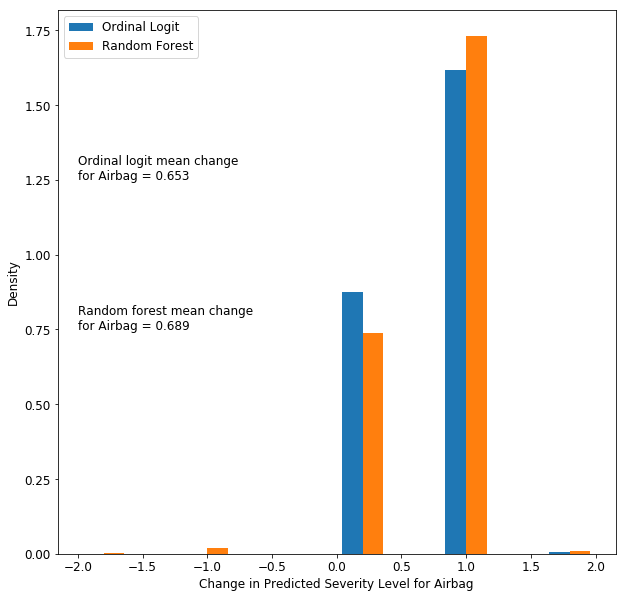

In [108]:
pdp_binary('Airbag', x=-2, y1=1.25, y2=0.75)

Airbag deployment appears to have a large impact on change in severity. As noted previously, the increase in severity associated with airbag deployment is likely due to airbags being deployed in high-energy collisions. Thus, it could be capturing the effects of unobserved variables (i.e., it is acting as a proxy for other variables not available/not included in the model).

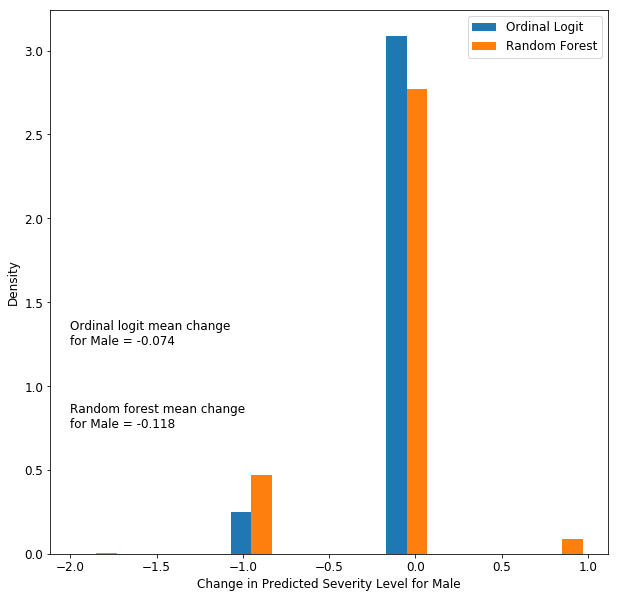

In [109]:
pdp_binary('Male', x=-2, y1=1.25, y2=0.75)

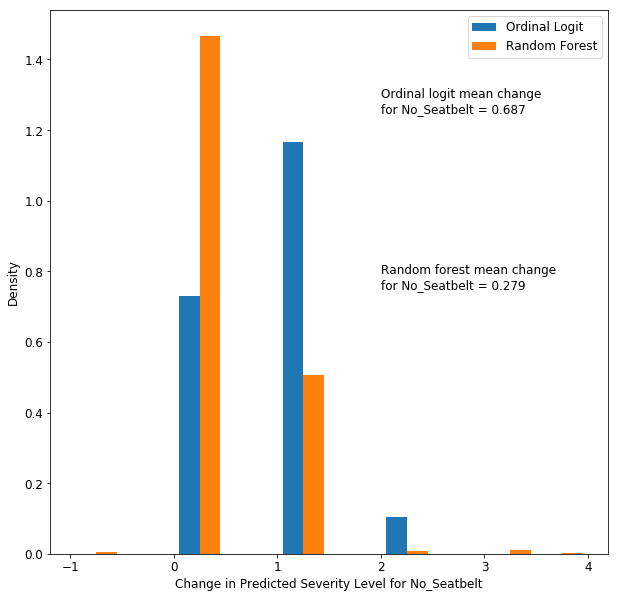

In [110]:
pdp_binary('No_Seatbelt', x=2, y1=1.25, y2=0.75)

Note that seatbelt use results in an increase in injury severity (with a few exceptions in the Random Forest model). This is consistent with expectations and research.

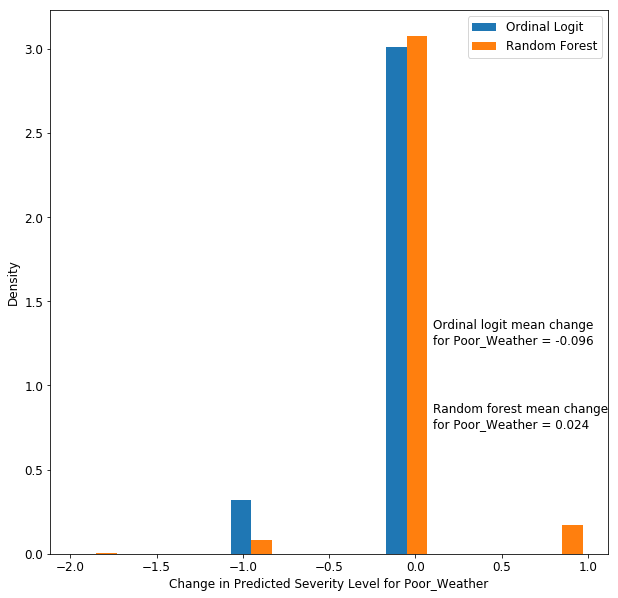

In [111]:
pdp_binary('Poor_Weather', x=0.1, y1=1.25, y2=0.75)

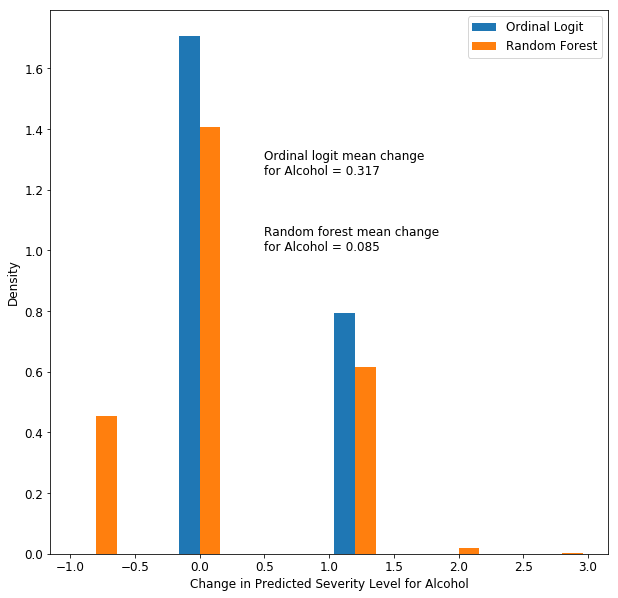

In [112]:
pdp_binary('Alcohol', x=0.5, y1=1.25, y2=1)

Note that alcohol use results in an increase in injury severity (with exceptions in the Random Forest model). This is consistent with expectations and research.

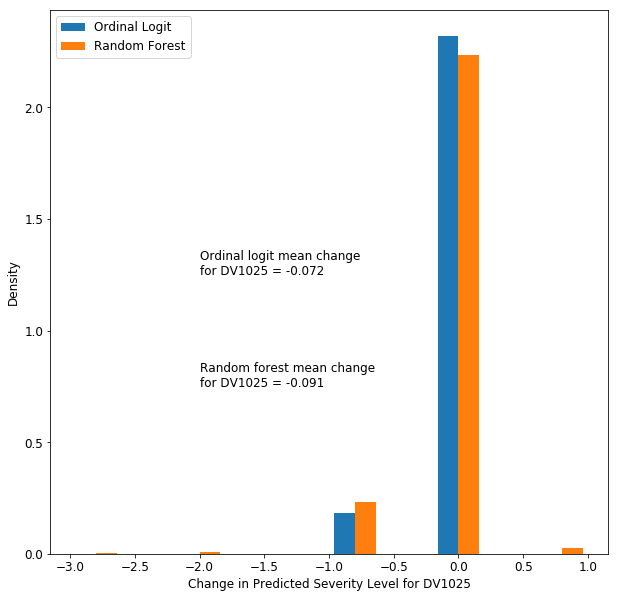

In [113]:
pdp_binary('DV1025', x=-2, y1=1.25, y2=0.75)

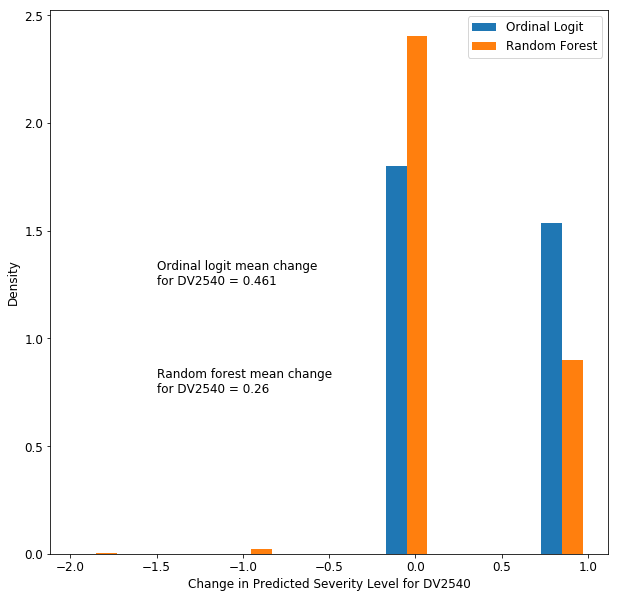

In [114]:
pdp_binary('DV2540', x=-1.5, y1=1.25, y2=0.75)

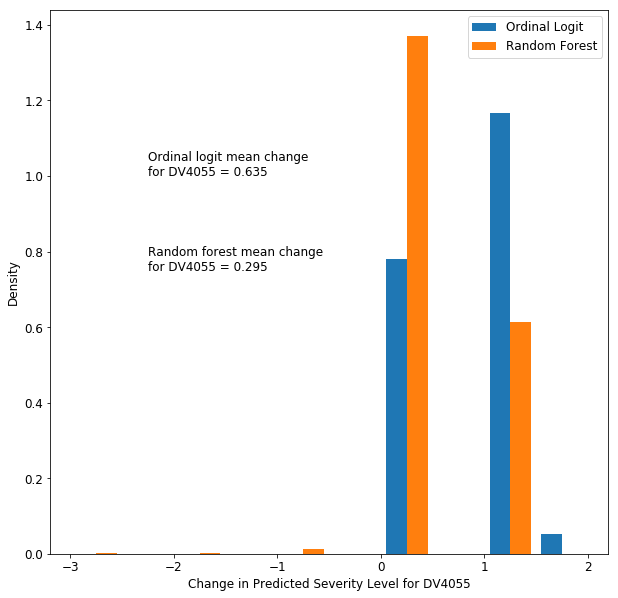

In [115]:
pdp_binary('DV4055', x=-2.25, y1=1, y2=0.75)

Larger change in speed = higher severity (exceptions in Random Forest)

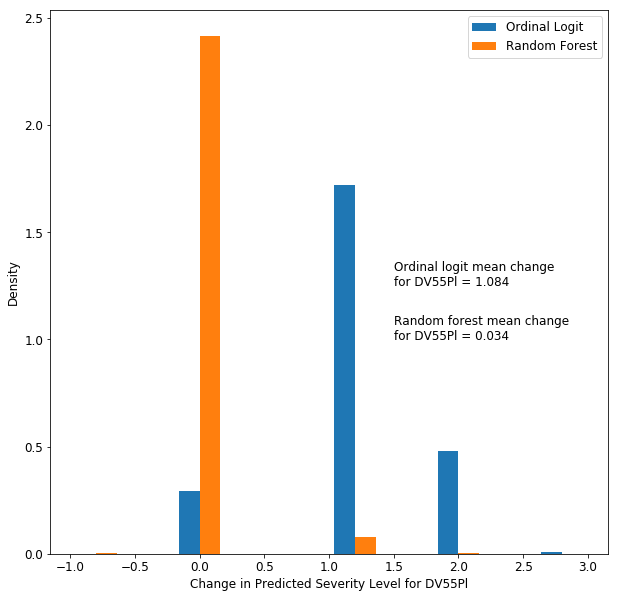

In [116]:
pdp_binary('DV55Pl', x=1.5, y1=1.25, y2=1)

Larger change in speed = higher severity (exceptions in Random Forest)

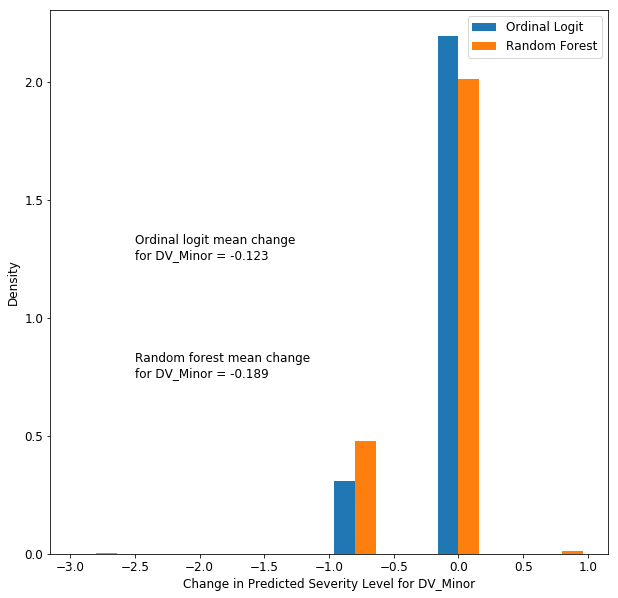

In [117]:
pdp_binary('DV_Minor', x=-2.5, y1=1.25, y2=0.75)

Small change in speed = lower severity (exceptions in Random Forest)

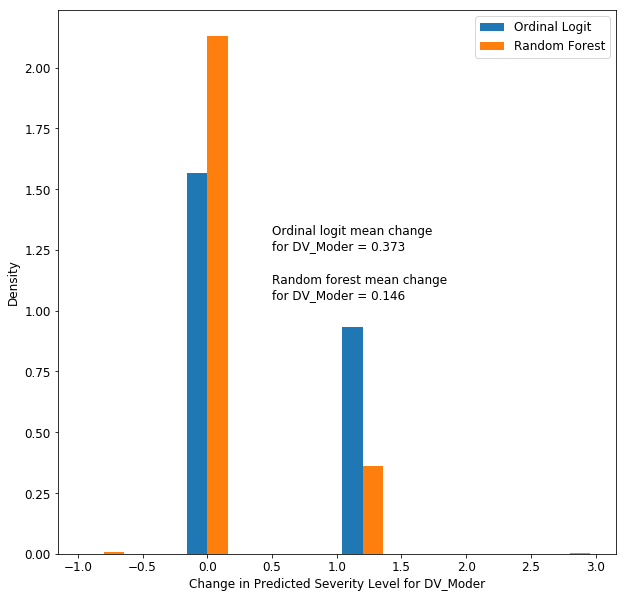

In [118]:
pdp_binary('DV_Moder', x=0.5, y1=1.25, y2=1.05)

Larger change in speed = higher severity (exceptions in Random Forest)

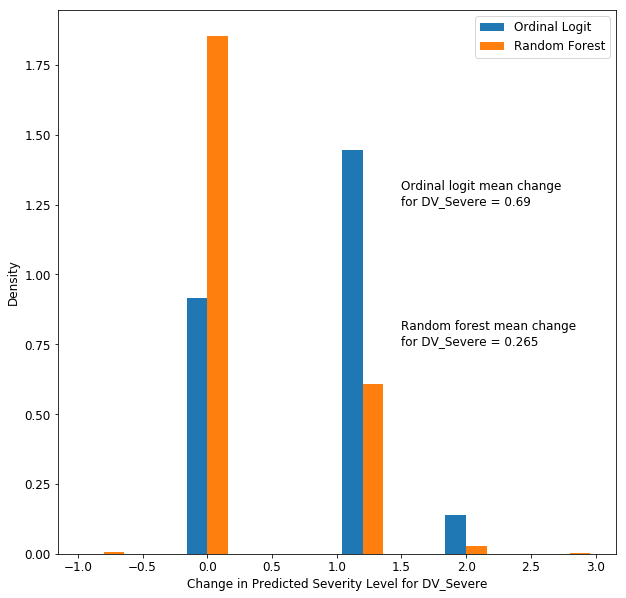

In [119]:
pdp_binary('DV_Severe', x=1.5, y1=1.25, y2=0.75)

Larger change in speed = higher severity (exceptions in Random Forest)

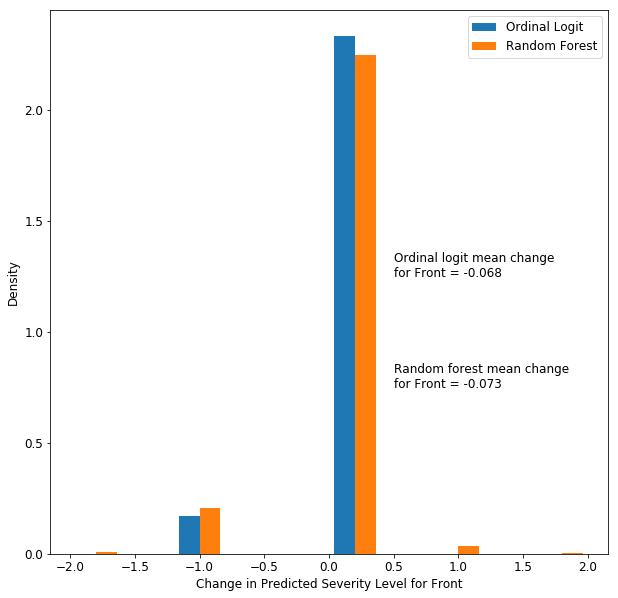

In [120]:
pdp_binary('Front', x=0.5, y1=1.25, y2=0.75)

Frontal impacts (i.e., front of vehicle) with same change in speed, etc., results in lower severity (some exceptions in Random Forest). This is not surprising given the focus on occupant protection and design of vehicles for frontal impacts (i.e., New Car Assessement Programs [NCAP] and Insurance Institute for Highway Safety).

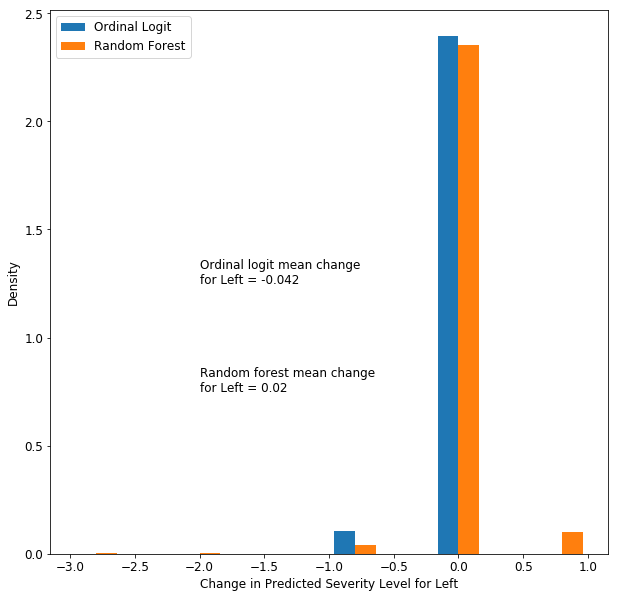

In [121]:
pdp_binary('Left', x=-2, y1=1.25, y2=0.75)

# Key Takeaways and Future Directions

Key findings include:
- Ordinal logit has better agreement between predicted and observed injury severities in both the training and test datasets (based on GK Gamma and confusion matrices)
- Ordinal logit forces a structure to the model, which may be one reason for the improved performance compared to the Random Forest (particularly when there is a known structure, such as ones based on physics and/or biomechanics - as there is in crashes)
- The plots are only for first-level effects. Interactions between variables have not been considered yet. This could be part of the reason that some of the random forest predictions are opposite from the ordinal logit.

Future analysis should evaluate:
- Effects of interactions between predictors
- Use additional years of data to increase sample sizes
- Look into observations where the direction of change in predictions is not what would be expected based on biomechanics/physics or the ordinal logit. This could potentially provide insights into real-world interactions and/or situations where technologies can be developed/improved to reduce injury severities
- Evaluate other machine learning methods, such as Gradient Boosting
- Compare results of machine learning models with other traditional statistical methods, such as mixed logistic regression.